# Importation des packages

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from collections import defaultdict

from tslearn.clustering import TimeSeriesKMeans

# Importation du dataset

In [ ]:
tseries = pd.read_csv("clients_menages_tabular_transfo.csv")
#tseries.date = pd.to_datetime(tseries.date, format='%Y%m%d')

In [ ]:
# Les dates enregistrées
dates = ['2018-01-31', '2018-02-28',
 '2018-03-31', '2018-04-30',
 '2018-05-31', '2018-06-30',
 '2018-07-31', '2018-08-31',
 '2018-09-30', '2018-10-31',
 '2018-11-30', '2018-12-31',
 '2019-01-31', '2019-02-28',
 '2019-03-31', '2019-04-30',
 '2019-05-31', '2019-06-30',
 '2019-07-31', '2019-08-31',
 '2019-09-30']
# Nous allons essayer de prédire les soldes. Les variables exogènes ne sont pas prises en compte pour le modèle ARIMA
MA_df = tseries[["id_client", "date", "solde_std"]]

# Prétraitement des données

In [ ]:
# Vérifier le pourcentage des lignes vides
len(MA_df[MA_df.isnull().any(axis=1)])/len(MA_df)

0.02018137244571822

In [ ]:
MA_df.dropna(axis=0,how='any',inplace=True)

In [ ]:
# Créer une dictionnaire pour stocker pour chaque client les observations lui concernant
MA_df_per_client = {}
for i in MA_df['id_client'].unique():
    df_temp = pd.DataFrame()
    df_temp['solde_std'] = MA_df[MA_df['id_client'] == i]['solde_std']
    df_temp['date'] = MA_df[MA_df['id_client'] == i]['date']
    
    #df_temp['MA_2m'] = df_temp['solde_std'].rolling(window=2).mean()
    #df_temp['MA_3m'] = df_temp['solde_std'].rolling(window=3).mean()
    MA_df_per_client[str(i)] = df_temp

In [ ]:
# Fonction permettant de récupérer les coefficients d'un modèle ARIMA
from sklearn.model_selection import train_test_split
def getCoef(data:pd.DataFrame,column:str,algorithm:type,kwds:dict,splitSize:float) -> dict:
    size = int(len(data) * splitSize)
    train, test = data.iloc[0:size][column].tolist(), data.iloc[size:len(data)][column].tolist()
    history = [x for x in train]

    model = algorithm(history, **kwds)
    model_fit = model.fit() 
    coefDict = {}
    coefDict['polynomial_ar'] = model_fit.polynomial_ar
    coefDict['polynomial_ma'] = model_fit.polynomial_ma
    coefDict['polynomial_seasonal_ar'] = model_fit.polynomial_seasonal_ar
    coefDict['polynomial_seasonal_ma'] = model_fit.polynomial_seasonal_ma
    coefDict['polynomial_trend'] = model_fit.polynomial_trend

    return coefDict


In [ ]:
import json
with open('optimal_parameters_client.json') as json_file:
    arimaParamDict = json.load(json_file)

In [ ]:
# Construire un dataframe dont chaque ligne représente un client unique et ses coefficients ARIMA
arimaCoefDf = pd.DataFrame()
for clientId,data in MA_df_per_client.items():
    orderArima = arimaParamDict[clientId]
    orderArima = orderArima.split(" ")
    orderArima = tuple([int(i) for i in orderArima])
    coefDict = getCoef(data,'solde_std',ARIMA,{'order':orderArima},0.8) 
    df_temp = pd.DataFrame()
    df_temp['id_client'] = pd.Series([int(clientId)])
    for coef,values in coefDict.items():
        list_values = values.tolist()
        if len(list_values)>0:
            for i in range(len(list_values)):
                df_temp[coef+'_'+str(i)]=pd.Series(list_values[i])
    # else:
    #     row_to_append = [int(clientId)]
    #     for coef,values in coefDict.items():
    #         list_values = values.tolist()
    #         if len(list_values)>0:
    #             row_to_append += list_values
    #     series_to_append = pd.Series(row_to_append, index = arimaCoefDf.columns)
    #     arimaCoefDf = arimaCoefDf.append(series_to_append, ignore_index=True)
    arimaCoefDf = pd.concat([arimaCoefDf,df_temp], axis=0, ignore_index=True)


In [ ]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns

In [ ]:
# df_standard = StandardScaler().fit_transform(arimaCoefDf[['polynomial_ma_1','polynomial_ar_1']])
# df_series = pd.DataFrame(df_standard).fillna(0)

In [ ]:
df = arimaCoefDf[['polynomial_ma_1','polynomial_ar_1']]
df.dropna(axis=0,how='any',inplace=True)
# df = pd.DataFrame(df).fillna(0)

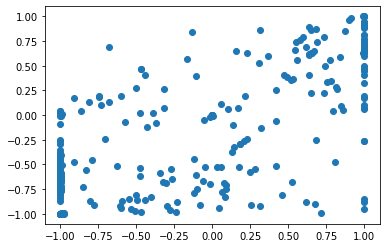

In [ ]:
plt.scatter(df['polynomial_ma_1'],df['polynomial_ar_1'])
plt.show()

In [ ]:
# Fonction pour la visualisation
def plotClusters(data, algorithm, args, kwds, showFigure = True):
    model = algorithm(*args, **kwds).fit(data)
    labels = model.labels_
    try:
        sil_score = silhouette_score(data,labels,metric='euclidean')
    except:
        sil_score = -2
        pass
    if showFigure:
        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
        colors = []
        colors_dict = {}
        for x in labels:
            if x >= 0:
                color = palette[x]
            else:
                color = (0.0, 0.0, 0.0)
            colors.append(color)
            if x not in colors_dict:
                colors_dict[x] = color
        print(colors_dict)
        plt.figure(figsize=(10,5))
        plt.scatter(data['polynomial_ma_1'], data['polynomial_ar_1'], c=colors)
        try:
            plt.scatter(
            x=model.cluster_centers_[:, 0],
            y=model.cluster_centers_[:, 1],
            marker='x',
            c="blue",
            s=128
        )
        except:
            pass
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
        plt.title(f"Clusters found by {str(algorithm.__name__)} - silhouette score: {sil_score}")
    return sil_score, model

# KMEANS

In [ ]:
max_clusters = 10
inertias = np.zeros(max_clusters)
for i in range(1, max_clusters):
    _, model = plotClusters(df, cluster.KMeans, (), {'n_clusters':i},showFigure=False)
    inertias[i] = model.inertia_

Text(0, 0.5, 'Inertie')

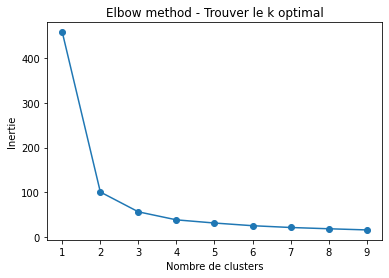

In [ ]:
plt.scatter(
    x=list(range(1, max_clusters)),
    y=inertias[1:]
)
plt.plot(list(range(1, max_clusters)),inertias[1:])
plt.title("Elbow method - Trouver le k optimal")
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')

{0: (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), 1: (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)}


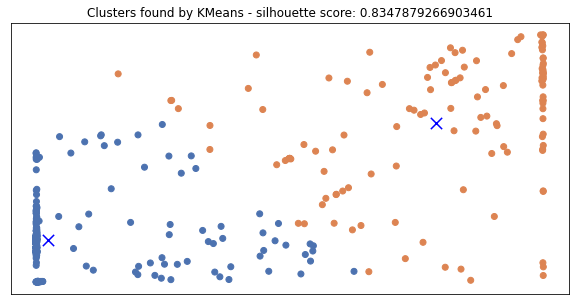

In [ ]:
sil_score_Kmeans, model_Kmeans = plotClusters(df, cluster.KMeans, (), {'n_clusters':2})

In [ ]:
labels = pd.Series(model_Kmeans.labels_,index=df.index)

In [ ]:
arimaCoefDf['cluster'] = labels

In [ ]:
arimaCoefDf['cluster'] = arimaCoefDf['cluster'].fillna(len(labels.unique()))

In [ ]:
arimaCoefDf[['id_client','polynomial_ma_1','polynomial_ar_1','cluster']].to_csv('clients_clustered_by_arima_coef.csv',index=False, encoding='utf-8')